In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torch
import pickle

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display


#other imports
import networkx as nx

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Load Data ===
with open('C:/Users/jakub/agi/data.pickle', 'rb') as f:
    data = pickle.load(f)

# === Graph Builder ===
def buildGraphs(data):
    graphs = []
    zs = [17, 21, 89, 93, 117, 121, 189, 193, 217, 221, 289, 293]

    for event in data:
        event = sorted(event, key=lambda x: x[0])
        X = [[hit[0], hit[1], hit[2]] for hit in event]  # Use only coordinates for features

        edge_index = []
        for i in range(len(event)):
            r1 = event[i][0]
            ir1 = next((idx for idx, z in enumerate(zs) if abs(r1 - z) < 2.0), None)
            if ir1 is None:
                continue

            for j in range(len(event)):
                if i == j:
                    continue
                r2 = event[j][0]
                ir2 = next((idx for idx, z in enumerate(zs) if abs(r2 - z) < 2.0), None)
                if ir2 is None:
                    continue
                if abs(ir1 - ir2) == 1 and i < j:
                    edge_index.append([i, j])

        # Plot scatter (optional)
        #for hit in X:
        #    plt.scatter(hit[0], hit[1])
        #plt.show()

        # Assign edge labels: 1 if track is correct, else 0
        y = [1 if event[i][3] == event[j][3] else 0 for i, j in edge_index]

        graphs.append(Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            y=torch.tensor(y, dtype=torch.float)
        ))
    return graphs

# === Graph Plot: Truth Labels ===
def plot_graph_with_truth(data_obj, index=None):
    G = nx.Graph()
    pos = {i: (coord[0], coord[1]) for i, coord in enumerate(data_obj.x.tolist())}
    G.add_nodes_from(pos.keys())

    edges = data_obj.edge_index.t().tolist()
    true_edges = [e for i, e in enumerate(edges) if data_obj.y[i] == 1]
    false_edges = [e for i, e in enumerate(edges) if data_obj.y[i] == 0]

    plt.figure(figsize=(10, 6))
    nx.draw_networkx_nodes(G, pos, node_color='hotpink', node_size=300)
    nx.draw_networkx_edges(G, pos, edgelist=true_edges, edge_color='hotpink', width=2, label='Correct (y=1)')
    nx.draw_networkx_edges(G, pos, edgelist=false_edges, edge_color='silver', style='dotted', label='Incorrect (y=0)')
    nx.draw_networkx_labels(G, pos, font_size=8)
    title = f"Event {index}: Hits with Track Truth Labels" if index is not None else "Graph of Hits with Track Truth Labels"
    plt.title(title)
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.show()

In [2]:
graphs = buildGraphs(data)
with open('data.pickle', 'wb') as f:
    pickle.dump(graphs, f)

In [3]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Generate event data from random parameters
def gen_edge_class(event_size_min, event_size_max, curve_min, curve_max, height, num_layers, max_angle, feature_scale, iter, num_samples):

    """ Feed params into randomiser """
    while True:
        radii, dirs, signs, event_size = rand_pars(event_size_min, event_size_max, curve_max, curve_min)
        xys = []
        X = np.empty([3,1])
        x = np.arange(0 + height/num_layers,height + height/num_layers, height/num_layers)
        i = 0
        for r, d, s in zip(radii, dirs, signs):
            y1test = y1(x, r, d, s)
        #     print(y1test, x)
            y2test = y2(x, r, d, s)
            if -2.5 < y1test[0] < 2.5 and not any(np.isnan(y1test)):
                X = np.append(X, np.vstack((y1test, np.array([i]*len(y1test)), x )), axis=1)
                i += 1
            if -2.5 < y2test[0] < 2.5 and not any(np.isnan(y2test)):
                X = np.append(X, np.vstack((y2test, np.array([i]*len(y2test)), x )), axis=1)
                i += 1
        X = X[:,1:].T
        np.random.shuffle(X)

        e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == layer+1) for j in np.argwhere(X[:,2] == (layer+2)) if (X[i, 0] - np.tan(max_angle/2) < X[j, 0] < X[i, 0] + np.tan(max_angle/2))]).T.squeeze()

        # This handles when no edges were constructed. In that case, the randomisation is a do-over
        try:
            y = np.array([int(i[1] == j[1]) for i,j in zip(X[e[0]], X[e[1]])])
            break
        except:
            pass
    if iter is not None and num_samples is not None:
        out.update(progress(iter, num_samples))

    X = np.array([X[:,2], X[:,0]]).T / feature_scale

    data = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y), pid = torch.from_numpy(X[:,1]))
    return data

In [4]:
train_size, test_size = 1000, 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('data.pickle', 'rb') as file:
    graphs = pickle.load(file)

# Ensure edge_index is of correct type
for g in graphs:
    g.edge_index = g.edge_index.long()
    g.to(device)

out = display(progress(0, len(graphs)), display_id=True)
train_dataset = graphs[:int(0.7 * len(graphs))]
test_dataset = graphs[int(0.3 * len(graphs)):]
out = display(progress(0, len(graphs)), display_id=True)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [5]:
print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

Fake / True =  0.9411764705882353


In [6]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 3, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
#model
model.to(device)

MPNN_Network(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
  )
  (edge_classifier): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [8]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [9]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

#%%time

epochs = 100
weight = 2

m_configs = {"input_dim": 3,"hidden_node_dim": 16,"hidden_edge_dim": 16,"in_layers": 1,"node_layers": 2,"edge_layers": 2,"n_graph_iters": 6,"layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad=True)

print(f"SizeOf train_dataset: {len(train_dataset)}\nSizeOf test_dataset: {len(test_dataset)}")

for epoch in range(epochs):
    ep += 1
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    v_acc, v_total_loss = evaluate(model, test_loader)
    v_loss_v.append(v_total_loss)
    v_acc_v.append(v_acc)

    print('Epoch: {}, Train accuracy: {:.4f}, val accuracy: {:.4f}'.format(ep, acc, v_acc))

SizeOf train_dataset: 93669
SizeOf test_dataset: 93670
Epoch: 1, Train accuracy: 0.5310, val accuracy: 0.5739
Epoch: 2, Train accuracy: 0.5761, val accuracy: 0.5785
Epoch: 3, Train accuracy: 0.5768, val accuracy: 0.5773
Epoch: 4, Train accuracy: 0.5769, val accuracy: 0.5779
Epoch: 5, Train accuracy: 0.5769, val accuracy: 0.5784
Epoch: 6, Train accuracy: 0.5770, val accuracy: 0.5781
Epoch: 7, Train accuracy: 0.5772, val accuracy: 0.5787
Epoch: 8, Train accuracy: 0.5774, val accuracy: 0.5798
Epoch: 9, Train accuracy: 0.5777, val accuracy: 0.5804
Epoch: 10, Train accuracy: 0.5781, val accuracy: 0.5812
Epoch: 11, Train accuracy: 0.5785, val accuracy: 0.5833
Epoch: 12, Train accuracy: 0.5790, val accuracy: 0.5823
Epoch: 13, Train accuracy: 0.5797, val accuracy: 0.5856
Epoch: 14, Train accuracy: 0.5804, val accuracy: 0.5876
Epoch: 15, Train accuracy: 0.5811, val accuracy: 0.5865
Epoch: 16, Train accuracy: 0.5818, val accuracy: 0.5911
Epoch: 17, Train accuracy: 0.5827, val accuracy: 0.5932
Ep

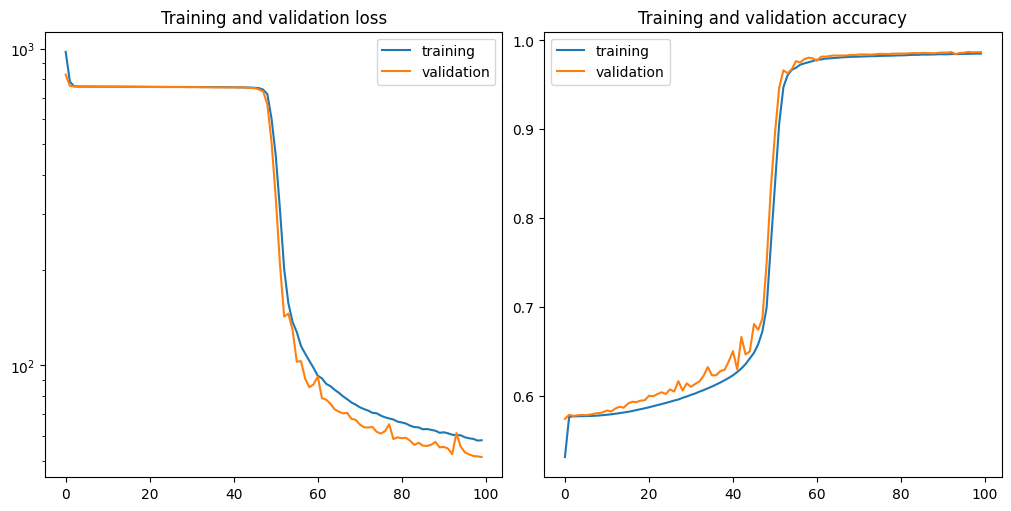

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, label="training")
axs[0].plot(np.arange(len(v_loss_v)), v_loss_v, label="validation")
axs[0].set_title("Training and validation loss")
axs[0].set_yscale("log")
axs[0].legend()
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, label="training")
axs[1].plot(np.arange(len(v_acc_v)), v_acc_v, label="validation")
axs[1].set_title("Training and validation accuracy")
axs[1].set_yscale("linear")
axs[1].legend()
#axs[1].set_ylim([0.92, np.max(t_acc_v)+0.001])

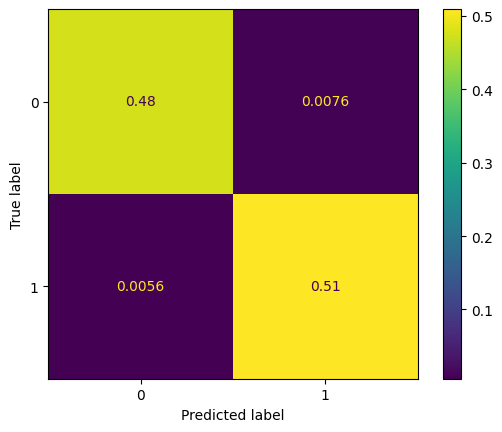

In [ ]:
import torch
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

y_test = torch.cat([data.y.cpu() for data in test_loader.dataset])
y_pred = torch.cat([torch.sigmoid(model(data.to(device))) > 0.6 for data in test_loader.dataset]).cpu()

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred,normalize="all")).plot()